In [91]:
import numpy as np
import scipy.stats
import pandas as pd
from os.path import join
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt

from src.utilities.utils import get_files

In [92]:
SMALL_SIZE  = 15
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size        = MEDIUM_SIZE)   # controls default text sizes
plt.rc('axes', titlesize   = SMALL_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize   = MEDIUM_SIZE)   # fontsize of the x and y labels
plt.rc('xtick', labelsize  = SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize  = SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize  = SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize = BIGGER_SIZE)   # fontsize of the figure title

In [ ]:
def get_acc_values(cpaths, clfs, op_values, index):

    accuracies = {k: None for k in clfs}

    for cl, path in zip(clfs, cpaths):
        ops = {k: None for k in op_values}

        for D, tau in op_values:
            metrics = "METRICS_[{}, {}].csv".format(D, tau)

            data = pd.read_csv(join(path, metrics))

            ### mean accuracy        
            ops[(D, tau)] = float(data["general.10"][1])

        accuracies[cl] = ops

    df_final       = pd.DataFrame(accuracies) * 100
    df_final.index = index
        
    return df_final

## D values

In [8]:
def plot_data_D(df, ticks, title, save_title):
    
    ax = df.plot(figsize = (12, 5), style = 'o-', legend = False)

    ax.set_xlabel("D values", fontsize = 20)
    plt.xticks(ticks)

    ax.set_ylabel("Accuracy (%)", fontsize = 20)
    plt.ylim((43, 80))
    
    ax.set_title(title, fontsize = 20)

    ax.grid(True, color = "lightgray", linestyle='-')
    
    ax.legend(frameon = True, ncol = 6)

    plt.tight_layout()

    plt.savefig('figs/' + save_title + '.pdf')

In [56]:
paths      = join("db", "GeoLife")
clf_paths  = get_files(paths, "classification", rec = True)

clfs       = ["k-NN", "SVM-R", "SVM-L", "DT", "RF", "XGBoost"]
op_values  = [(3, 1), (4, 1), (5, 1), (6, 1)]
index      = [3, 4, 5, 6]

In [57]:
df_pe       = get_acc_values(clf_paths[0:6], clfs, op_values, index)
df_sc       = get_acc_values(clf_paths[6:12], clfs, op_values, index)
df_st       = get_acc_values(clf_paths[12:18], clfs, op_values, index)
df_pe_sc    = get_acc_values(clf_paths[18:24], clfs, op_values, index)
df_pe_sc_st = get_acc_values(clf_paths[24:30], clfs, op_values, index)

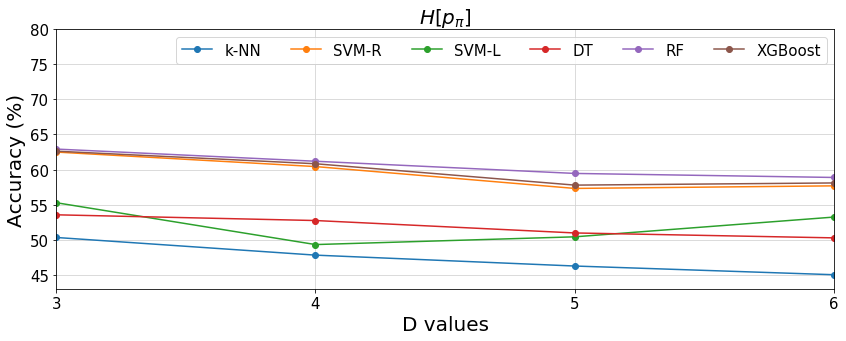

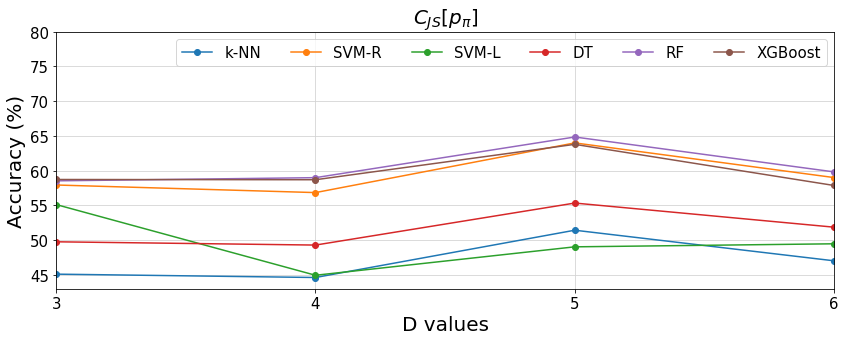

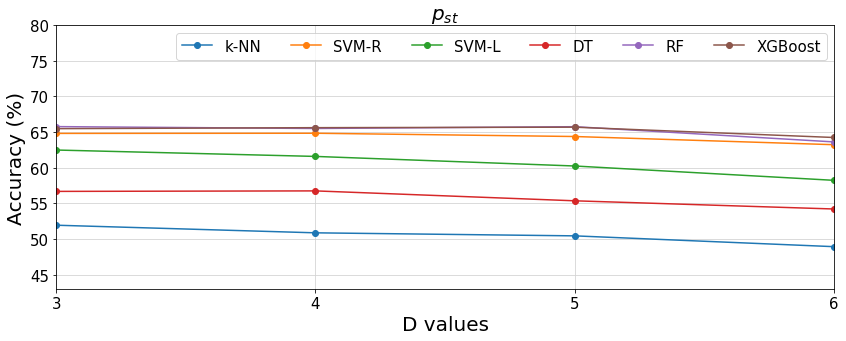

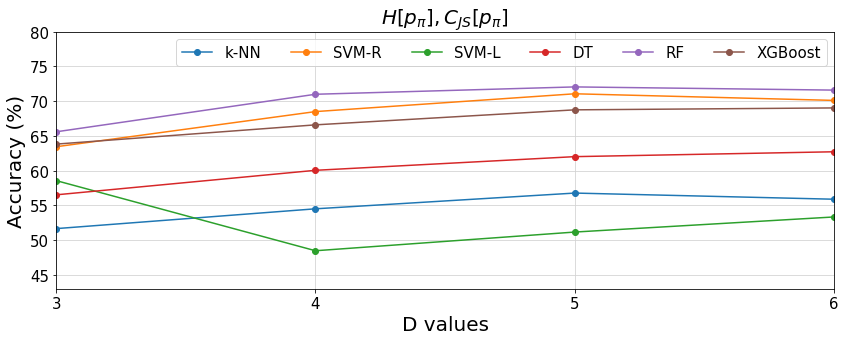

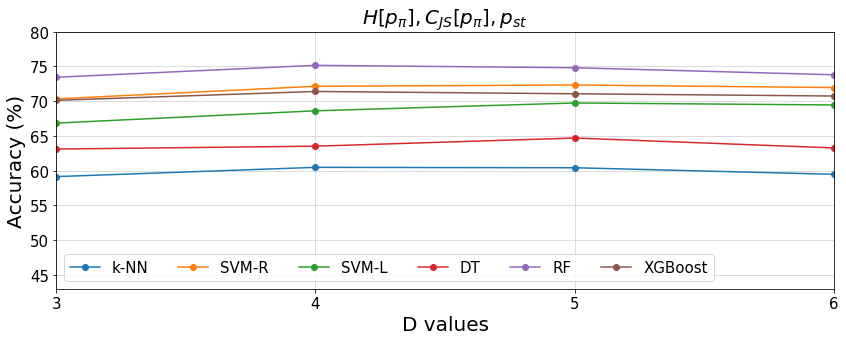

In [58]:
ax1 = plot_data_D(df_pe, index, r'$H[p_\pi]$', "[D_t1]_perm")
ax2 = plot_data_D(df_sc, index, r'$C_{JS}[p_\pi]$', "[D_t1]_comp")
ax3 = plot_data_D(df_st, index, r'$p_{st}$', "[D_t1]_self_prob")
ax4 = plot_data_D(df_pe_sc, index, r'$H[p_\pi], C_{JS}[p_\pi]$', "[D_t1]_perm_comp")
ax5 = plot_data_D(df_pe_sc_st, index, r'$H[p_\pi], C_{JS}[p_\pi], p_{st}$', "[D_t1]_perm_comp_self")

## $\tau$ values

In [13]:
def plot_data_tau(df, ticks, title, save_title):
    
    ax = df.plot(figsize = (12, 5), style = 'o-', legend = False)

    ax.set_xlabel(r"$\tau$ values", fontsize = 20)
    plt.xticks(ticks)

    ax.set_ylabel("Accuracy (%)", fontsize = 20)
    plt.ylim((33, 78))
    
    ax.set_title(title, fontsize = 20)

    ax.grid(True, color = "lightgray", linestyle='-')
    
    ax.legend(frameon = True, ncol = 6)

    plt.tight_layout()

    plt.savefig('figs/' + save_title + '.pdf')

In [10]:
paths      = join("db", "GeoLife")
clf_paths  = get_files(paths, "classification", rec = True)

clfs       = ["k-NN", "SVM-R", "SVM-L", "DT", "RF", "XGBoost"]

op_values  = [(4, 1), (4, 3), (4, 5), (4, 10), (4, 15)]

index      = [1, 3, 5, 10, 15]

In [11]:
df_pe       = get_acc_values(clf_paths[30:36], clfs, op_values, index)
df_sc       = get_acc_values(clf_paths[36:42], clfs, op_values, index)
df_st       = get_acc_values(clf_paths[42:48], clfs, op_values, index)
df_pe_sc    = get_acc_values(clf_paths[48:54], clfs, op_values, index)
df_pe_sc_st = get_acc_values(clf_paths[54:60], clfs, op_values, index)

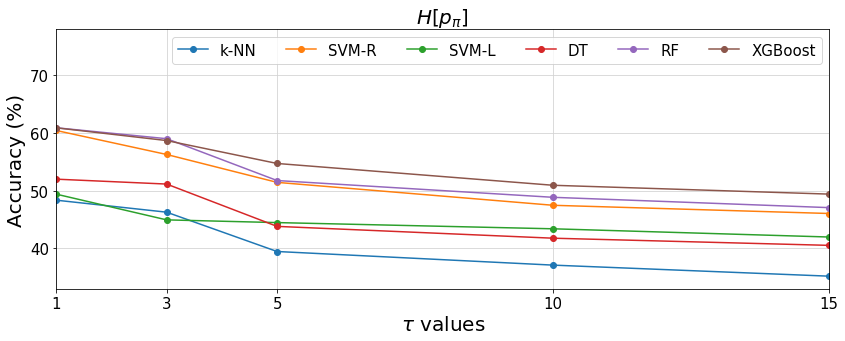

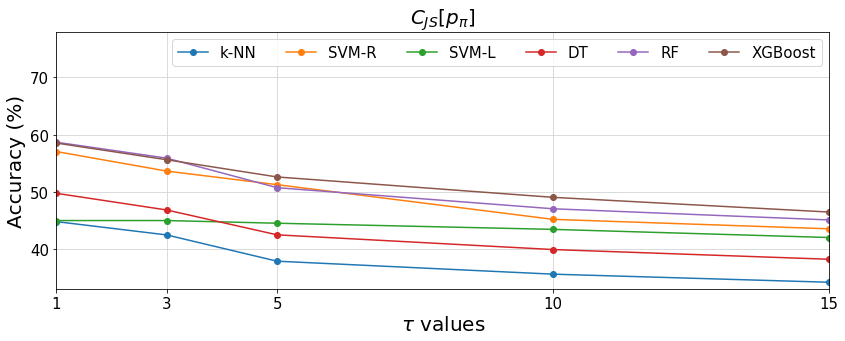

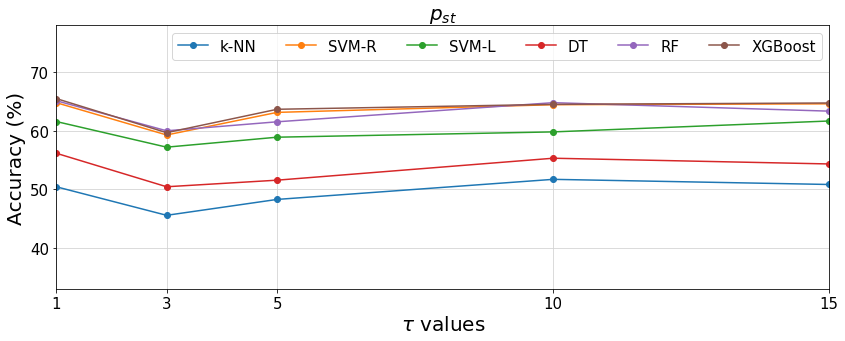

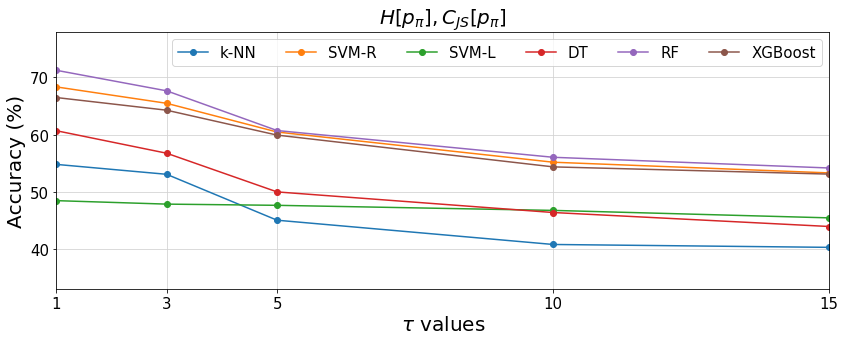

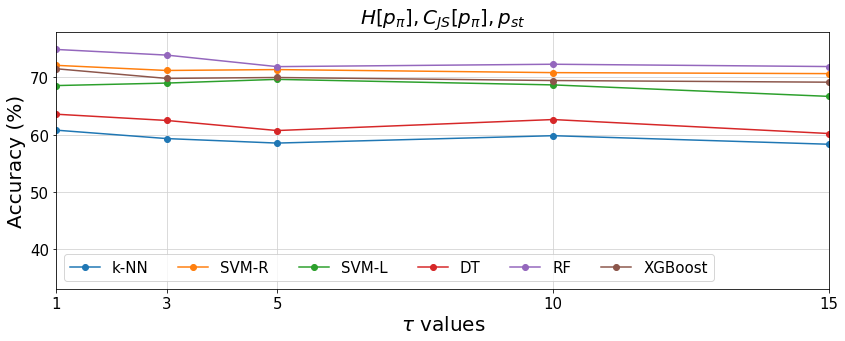

In [14]:
ax1 = plot_data_tau(df_pe, index, r'$H[p_\pi]$', "[D4_t]_perm")
ax2 = plot_data_tau(df_sc, index, r'$C_{JS}[p_\pi]$', "[D4_t]_comp")
ax3 = plot_data_tau(df_st, index, r'$p_{st}$', "[D4_t]_self_prob")
ax4 = plot_data_tau(df_pe_sc, index, r'$H[p_\pi], C_{JS}[p_\pi]$', "[D4_t]_perm_comp")
ax5 = plot_data_tau(df_pe_sc_st, index, r'$H[p_\pi], C_{JS}[p_\pi], p_{st}$', "[D4_t]_perm_comp_self")

## Classification results

In [6]:
def mean_confidence_interval(data, confidence = 0.95):
    a     = 1.0 * np.array(data)
    n     = len(a)
    
    m, se = np.mean(a), scipy.stats.sem(a)
    h     = se * scipy.stats.t.ppf((1 + confidence) / 2., n - 1)
    return m, h


def get_statistics(data, classes, kind, n_folds, metric):
    
    dstats = {k: [] for k in classes}
    cint   = {k: [] for k in classes}

    for v in range(n_folds):
        if v == 0:
            values = "{}".format(kind)
        else:
            values = "{}.{}".format(kind, v)
            
        stat = [x for x in data[values][metric].replace("[", '').replace("]", '').split(" ") if len(x) > 0]
        stat = list(map(float, stat))
        
        if metric != 1:
            for enum, c in enumerate(classes):
                dstats[c].append(stat[enum] * 100)
        
        else:
            enum = 0
            for c in classes:
                dstats[c].append(stat[enum] * 100)
            
    for s in classes:
        cint[s] = mean_confidence_interval(dstats[s], confidence = 0.95)
            
    return dstats, cint

In [10]:
def print_values(folder, classes, n_folds, kind):
    path    = join("db", "GeoLife", folder, "METRICS_[4, 1].csv")
    data    = pd.read_csv(path)
    
    dacc, cacc = get_statistics(data, classes, kind, n_folds, 1)
    df1, cf1   = get_statistics(data, classes, kind, n_folds, 2)
    drec, crec = get_statistics(data, classes, kind, n_folds, 3)
    dpre, cpre = get_statistics(data, classes, kind, n_folds, 4)

    print("Accuracy: {:.4} (+- {:.2})".format(cacc[classes[0]][0], cacc[classes[0]][1]))

    for c in classes:
        string = "\n--- {} ---\n F1 : {:.4} (+- {:.2})\n REC: {:.4} (+- {:.2})\n PRE: {:.4} (+- {:.2})\n"
        print(string.format(c, cf1[c][0], cf1[c][1], crec[c][0], crec[c][1], cpre[c][0], cpre[c][1]))

In [11]:
## metric: 2 F1, 3 recall, 4 precision
kind    = "perclass"
n_folds = 10

In [12]:
folder  = "classification_2021-02-17 11:11:34.626473"
classes = ["bike", "bus", "driving", "walk"]

print_values(folder, classes, n_folds, kind)

Accuracy: 74.89 (+- 1.1)

--- bike ---
 F1 : 65.64 (+- 2.4)
 REC: 57.75 (+- 3.1)
 PRE: 76.38 (+- 3.1)


--- bus ---
 F1 : 72.53 (+- 2.1)
 REC: 70.74 (+- 2.7)
 PRE: 74.54 (+- 2.5)


--- driving ---
 F1 : 64.67 (+- 2.0)
 REC: 56.94 (+- 2.2)
 PRE: 74.93 (+- 2.3)


--- walk ---
 F1 : 81.67 (+- 0.87)
 REC: 90.0 (+- 1.2)
 PRE: 74.78 (+- 1.2)



In [13]:
folder  = "classification_2021-02-17 16:09:05.757774"
classes = ["bike", "walk"]

print_values(folder, classes, n_folds, kind)

Accuracy: 84.46 (+- 1.2)

--- bike ---
 F1 : 68.8 (+- 2.7)
 REC: 59.32 (+- 3.0)
 PRE: 82.0 (+- 2.3)


--- walk ---
 F1 : 89.65 (+- 0.75)
 REC: 94.71 (+- 0.68)
 PRE: 85.12 (+- 0.98)



In [14]:
folder  = "classification_2021-02-17 16:09:48.377298"
classes = ["bus", "walk"]

print_values(folder, classes, n_folds, kind)

Accuracy: 90.88 (+- 0.87)

--- bus ---
 F1 : 84.94 (+- 1.4)
 REC: 79.9 (+- 1.4)
 PRE: 90.67 (+- 1.7)


--- walk ---
 F1 : 93.46 (+- 0.62)
 REC: 96.09 (+- 0.72)
 PRE: 90.97 (+- 0.63)



In [15]:
folder  = "classification_2021-02-17 16:10:13.152017"
classes = ["driving", "walk"]

print_values(folder, classes, n_folds, kind)

Accuracy: 91.41 (+- 0.62)

--- driving ---
 F1 : 81.47 (+- 1.4)
 REC: 74.03 (+- 2.0)
 PRE: 90.69 (+- 2.1)


--- walk ---
 F1 : 94.41 (+- 0.4)
 REC: 97.37 (+- 0.64)
 PRE: 91.63 (+- 0.57)



In [16]:
folder  = "classification_2021-02-17 16:10:33.282537"
classes = ["bike", "driving"]

print_values(folder, classes, n_folds, kind)

Accuracy: 88.75 (+- 1.2)

--- bike ---
 F1 : 89.78 (+- 1.1)
 REC: 91.02 (+- 1.9)
 PRE: 88.66 (+- 1.7)


--- driving ---
 F1 : 87.46 (+- 1.4)
 REC: 86.04 (+- 2.6)
 PRE: 89.08 (+- 2.0)



In [17]:
folder  = "classification_2021-02-17 16:10:49.108216"
classes = ["bus", "driving"]

print_values(folder, classes, n_folds, kind)

Accuracy: 79.6 (+- 1.9)

--- bus ---
 F1 : 82.92 (+- 1.6)
 REC: 85.29 (+- 2.0)
 PRE: 80.73 (+- 1.8)


--- driving ---
 F1 : 74.64 (+- 2.5)
 REC: 71.72 (+- 3.1)
 PRE: 77.94 (+- 2.6)



In [18]:
folder  = "classification_2021-02-17 16:11:02.299001"
classes = ["bike", "bus"]

print_values(folder, classes, n_folds, kind)

Accuracy: 88.58 (+- 0.75)

--- bike ---
 F1 : 87.99 (+- 0.8)
 REC: 90.65 (+- 1.5)
 PRE: 85.54 (+- 1.2)


--- bus ---
 F1 : 89.1 (+- 0.73)
 REC: 86.8 (+- 1.4)
 PRE: 91.58 (+- 1.2)



In [22]:
#### confusion matrix
path    = join("db", "GeoLife", "classification_2021-02-17 11:11:34.626473", "ConfusionMatrices_[4, 1].txt")
cm         = pd.read_csv(path, skiprows = 50, sep = ' ')

cm.columns = ["bike", "bus", "driving", "walk"]
cm.index   = ["bike", "bus", "driving", "walk"]

cm

,bike,bus,driving,walk
bike,920,64,21,588
bus,57,1313,174,312
driving,28,260,763,289
walk,203,127,61,3519


In [96]:
SMALL_SIZE  = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 30

plt.rc('font', size        = MEDIUM_SIZE)   # controls default text sizes
plt.rc('axes', titlesize   = SMALL_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize   = MEDIUM_SIZE)   # fontsize of the x and y labels
plt.rc('xtick', labelsize  = SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize  = SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize  = SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize = BIGGER_SIZE)   # fontsize of the figure title

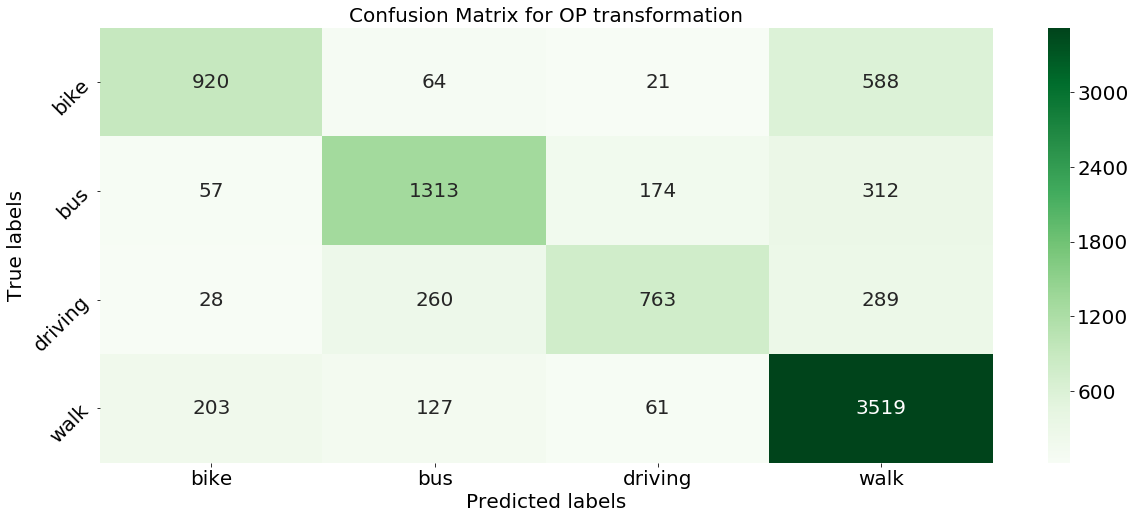

In [97]:
plt.figure(figsize=(20, 8)) 

ax = plt.subplot()
sns_plot = sns.heatmap(cm, annot = True, ax = ax, cmap = 'Greens', fmt = 'g') #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix for OP transformation') 

ax.xaxis.set_ticklabels(classes)
ax.yaxis.set_ticklabels(classes, rotation = 45)

fig = sns_plot.get_figure()

save_title = "confusion_matrix"
plt.savefig('figs/' + save_title + '.pdf', dpi = 600)

### Statistics about the dataset

In [137]:
def get_size(folder, tau):
    
    data  = pd.read_csv(join("db", "GeoLife", folder, f"DATASET__op_[4, {tau}].csv"))
    
    size  = len(data)
    
    count = Counter(data["classes"])
    
    
    print(f"For tau = {tau}: n  = {size}")
    
    print(count)
    
    probs = [(x1, x2 / size) for x1, x2 in count.items()]
    
    for c, p in probs:
        print(f"Probs: {c} -- {p}")
        
    print()

In [138]:
folder = "classification_2021-02-17 11:02:18.436427"
taus   = [1, 3, 5, 10, 15]

for tau in taus:
    get_size(folder, tau)

For tau = 1: n  = 8699
Counter({'walk': 3910, 'bus': 1856, 'bike': 1593, 'driving': 1340})
Probs: bus -- 0.2133578572249684
Probs: driving -- 0.15404069433268192
Probs: walk -- 0.4494769513737211
Probs: bike -- 0.18312449706862857

For tau = 3: n  = 8699
Counter({'walk': 3910, 'bus': 1856, 'bike': 1593, 'driving': 1340})
Probs: bus -- 0.2133578572249684
Probs: driving -- 0.15404069433268192
Probs: walk -- 0.4494769513737211
Probs: bike -- 0.18312449706862857

For tau = 5: n  = 8519
Counter({'walk': 3789, 'bus': 1836, 'bike': 1578, 'driving': 1316})
Probs: bus -- 0.2155182533161169
Probs: driving -- 0.15447822514379622
Probs: walk -- 0.444770512971006
Probs: bike -- 0.18523300856908087

For tau = 10: n  = 8099
Counter({'walk': 3515, 'bus': 1807, 'bike': 1526, 'driving': 1251})
Probs: bus -- 0.2231139646869984
Probs: driving -- 0.15446351401407582
Probs: walk -- 0.43400419804914186
Probs: bike -- 0.18841832324978391

For tau = 15: n  = 7676
Counter({'walk': 3222, 'bus': 1774, 'bike': 147

In [144]:
classes         = ['walk', 'bus', 'car', 'bike', 'taxi']
folder_segments = join("db", "GeoLife", "segments")

In [145]:
for transport in classes:
    segment_size = []
    
    print(transport)
    
    query               = transport + "*.csv"
    user_transportation = get_files(folder_segments, query, True)

    for ind in range(len(user_transportation)):

        n = len(pd.read_csv(user_transportation[ind]))
        segment_size.append(n)
    
    print("mean (std): {:.02f} (+- {:.02f})".format(np.mean(segment_size), np.std(segment_size)))
    print("max trajectory size: {}; min trajectory size: {}".format(max(segment_size), min(segment_size)))
    print()

walk
mean (std): 412.86 (+- 1038.21)
max trajectory size: 19836; min trajectory size: 11

bus
mean (std): 691.88 (+- 911.13)
max trajectory size: 19604; min trajectory size: 11

car
mean (std): 627.88 (+- 866.97)
max trajectory size: 8394; min trajectory size: 12

bike
mean (std): 602.23 (+- 972.73)
max trajectory size: 22080; min trajectory size: 11

taxi
mean (std): 470.92 (+- 758.70)
max trajectory size: 10841; min trajectory size: 11



In [147]:
classes  = ['car', 'taxi']

segment_size = []

for transport in classes:
        
    print(transport)
    
    query               = transport + "*.csv"
    user_transportation = get_files(folder_segments, query, True)

    for ind in range(len(user_transportation)):

        n = len(pd.read_csv(user_transportation[ind]))
        segment_size.append(n)

print("mean (std): {:.02f} (+- {:.02f})".format(np.mean(segment_size), np.std(segment_size)))
print("max trajectory size: {}; min trajectory size: {}".format(max(segment_size), min(segment_size)))

car
taxi
mean (std): 567.44 (+- 830.48)
max trajectory size: 10841; min trajectory size: 11


In [148]:
classes  = ['walk', 'bus', 'car', 'bike', 'taxi']

segment_size = []

for transport in classes:
        
    print(transport)
    
    query               = transport + "*.csv"
    user_transportation = get_files(folder_segments, query, True)

    for ind in range(len(user_transportation)):

        n = len(pd.read_csv(user_transportation[ind]))
        segment_size.append(n)

print("mean (std): {:.02f} (+- {:.02f})".format(np.mean(segment_size), np.std(segment_size)))
print("max trajectory size: {}; min trajectory size: {}".format(max(segment_size), min(segment_size)))

walk
bus
car
bike
taxi
mean (std): 530.88 (+- 976.75)
max trajectory size: 22080; min trajectory size: 11
